<a href="https://colab.research.google.com/github/dmehdipour/pytorch/blob/main/MultiClass_ClassificationModel_Make_Blobs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

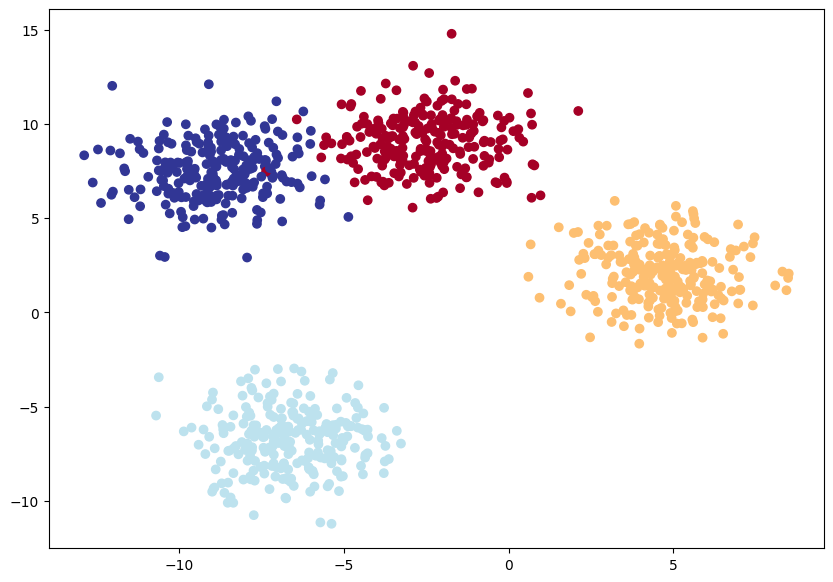

In [3]:
N_SAMPLES = 1000
N_FEATURES = 2
N_ClASSES = 4
RANDOM_SEED = 42
N_STD_CLUSTER=1.5

X_blob, y_blob = make_blobs(n_samples=N_SAMPLES,
                            n_features=N_FEATURES,
                            centers=N_ClASSES,
                            cluster_std=N_STD_CLUSTER,
                            shuffle=True,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.long)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu);

In [4]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

class BlobModelV1(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """Initializes multi-class classification model.

    Args:
      input_features (int): Number of input features to the model
      output_features (int): Number of output features (number of output classes)
      hidden_units (int): Number of hidden units between layers, default 8

    Returns:

    Example:
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_1 = BlobModelV1(input_features=2,
                      output_features=4,
                      hidden_units=8).to(device)

model_1

BlobModelV1(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [5]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [7]:
model_1.eval()
with torch.inference_mode():
  y_logits = model_1(X_blob_test.to(device))
y_logits[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')

In [8]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:5]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')

In [9]:
torch.sum(y_pred_probs[0]), torch.max(y_pred_probs[0]), torch.argmax(y_pred_probs[0])

(tensor(1., device='cuda:0'),
 tensor(0.3244, device='cuda:0'),
 tensor(1, device='cuda:0'))

In [10]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([1, 0, 0, 0, 0], device='cuda:0')

In [11]:
def accuracy_fn(y_true, y_pred):
  currect = torch.eq(y_true, y_pred).sum().item()
  acc = (currect/len(y_pred))*100
  return acc

In [12]:
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  train_loss = loss_fn(y_logits,
                       y_blob_train)
  train_acc=accuracy_fn(y_true=y_blob_train,
                  y_pred=y_pred)
  
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits,
                        y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)
    
  if epoch%10==0:
    print(f"Epoch: {epoch} | Train_loss:{train_loss:.4f}, Train_acc:{train_acc:.2f}% | Test_loss{test_loss:.4f}, Test_acc{test_acc:.2f}%")

Epoch: 0 | Train_loss:1.1588, Train_acc:40.38% | Test_loss1.0755, Test_acc48.00%
Epoch: 10 | Train_loss:0.6448, Train_acc:96.75% | Test_loss0.6607, Test_acc97.50%
Epoch: 20 | Train_loss:0.4254, Train_acc:98.50% | Test_loss0.4307, Test_acc100.00%
Epoch: 30 | Train_loss:0.2529, Train_acc:99.12% | Test_loss0.2451, Test_acc99.50%
Epoch: 40 | Train_loss:0.1123, Train_acc:99.25% | Test_loss0.1023, Test_acc99.50%
Epoch: 50 | Train_loss:0.0663, Train_acc:99.25% | Test_loss0.0585, Test_acc99.50%
Epoch: 60 | Train_loss:0.0507, Train_acc:99.25% | Test_loss0.0429, Test_acc99.50%
Epoch: 70 | Train_loss:0.0430, Train_acc:99.25% | Test_loss0.0349, Test_acc99.50%
Epoch: 80 | Train_loss:0.0384, Train_acc:99.25% | Test_loss0.0299, Test_acc99.50%
Epoch: 90 | Train_loss:0.0352, Train_acc:99.25% | Test_loss0.0266, Test_acc99.50%


In [13]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("File is already exist")
else:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py","wb") as f:
    f.write(request.content)

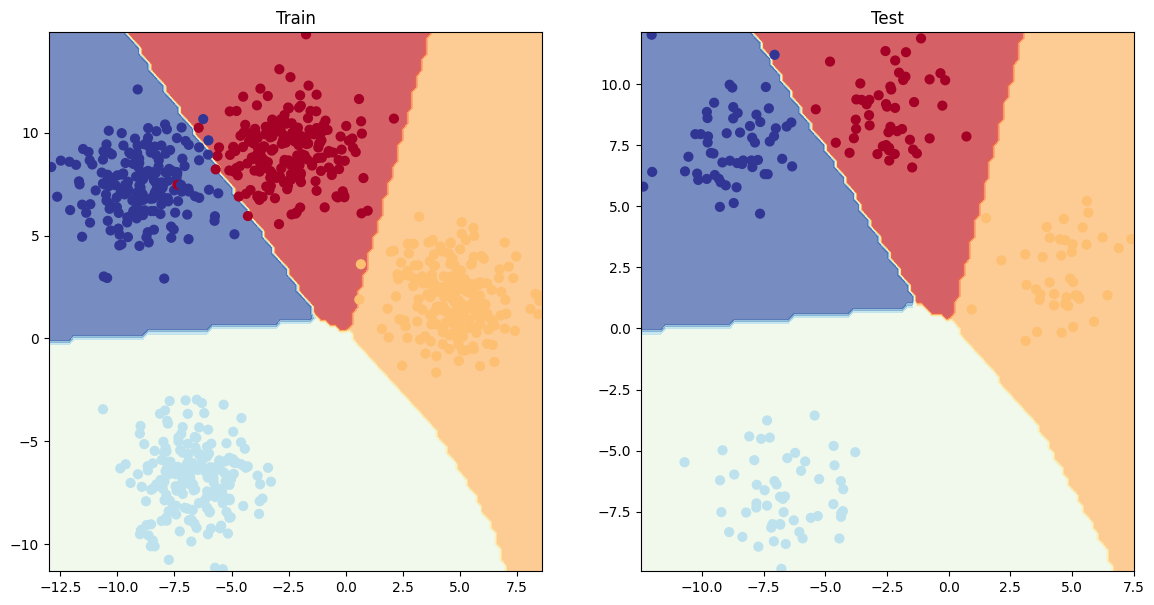

In [14]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,
                       X_blob_train,
                       y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,
                       X_blob_test,
                       y_blob_test)

In [15]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 32.4 MB/s eta 0:00:00


In [16]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix

torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)
torchmetrics_precision = Precision(task="multiclass", average='macro', num_classes=4).to(device)
torchmetrics_recall = Recall(task="multiclass", average='macro', num_classes=4).to(device)
torchmetrics_f1score = F1Score(task="multiclass", num_classes=4).to(device)
torchmetrics_confusionMatrix = ConfusionMatrix(task="multiclass", num_classes=4).to(device)

print(f"Accuracy: {torchmetrics_accuracy(test_pred, y_blob_test)*100:.2f} | Precision: {torchmetrics_precision(test_pred, y_blob_test)*100:.2f} | Recall: {torchmetrics_recall(test_pred, y_blob_test)*100:.2f} | F1Score: {torchmetrics_f1score(test_pred, y_blob_test)*100:.2f}")
print(f"\nConfusionMatrix:\n {torchmetrics_confusionMatrix(test_pred, y_blob_test)}")

Accuracy: 99.50 | Precision: 99.50 | Recall: 99.56 | F1Score: 99.50

ConfusionMatrix:
 tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 1,  0,  0, 56]], device='cuda:0')


In [17]:
from torchmetrics.classification import MulticlassAccuracy, MulticlassPrecision

torchmetrics_accuracy = MulticlassAccuracy(num_classes=4).to(device)
torchmetrics_percision = MulticlassPrecision(num_classes=4).to(device)

print(f"Accuracy: {torchmetrics_accuracy(test_pred, y_blob_test)*100:.2f} | Precision: {torchmetrics_precision(test_pred, y_blob_test)*100:.2f}")

Accuracy: 99.56 | Precision: 99.50
